## Inference using the trained model

In [8]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import math
import json

from IPython.display import Image, display
import random
import jieba

import tensorflow as tf

import config
import inference_wrapper
from inference_utils import caption_generator
from inference_utils import vocabulary

In [9]:
checkpoint_path="../model/show_and_tell_model/model.ckpt-0"
vocab_file="../data/word_counts.txt"
data_path="../data/"
# dev set
devset_path = os.path.join(data_path, "ai_challenger_caption_validation_20170910")
dev_image_path = os.path.join(devset_path, "caption_validation_images_20170910")
dev_annotation_path = os.path.join(devset_path, "caption_validation_annotations_20170910.json")

In [10]:
# load model
g = tf.Graph()
with g.as_default():
    model = inference_wrapper.InferenceWrapper()
    restore_fn = model.build_graph(checkpoint_path)
g.finalize()

vocab = vocabulary.Vocabulary(vocab_file)
sess = tf.Session(graph=g)
restore_fn(sess)
generator = caption_generator.CaptionGenerator(model, vocab)

INFO:tensorflow:Building model.


ValueError: Variable lstm/dense/kernel does not exist, or was not created with tf.get_variable(). Did you mean to set reuse=None in VarScope?

In [7]:
def show_example(example, image_path):
    image_id = example['image_id']
    caption = example['caption']
    im = Image(filename=os.path.join(image_path, image_id)) 
    display(im)
    for c in caption:
        c = c.strip().strip(u"。").replace('\n', '')
        seg_list = jieba.cut(c, cut_all=False)
        print ' '.join(seg_list)
    #return image_id, caption

In [8]:
# read dev data
input = open(dev_annotation_path,'r')
dev_examples = json.load(input)
input.close()
dev_size = len(dev_examples)

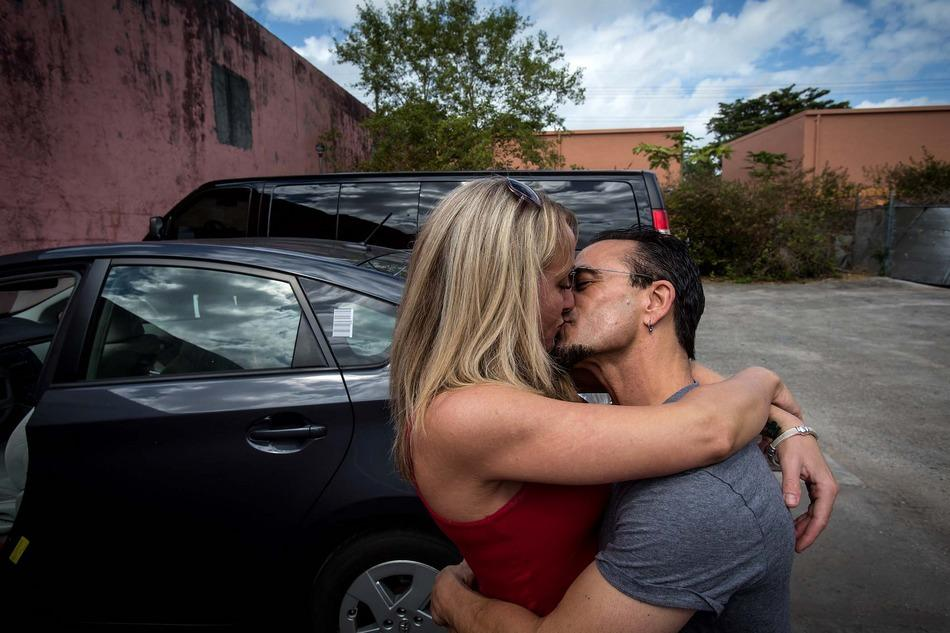

两个 相互 搂抱 的 人 在 道路 上 的 汽车 旁 接吻
一对 衣着 休闲 的 男女 在 道路 上 的 汽车 旁 亲吻
一个 男人 抱 着 一个 女人 在 道路 上 的 汽车 旁 亲吻
两个 互相 搂 着 的 人 站 在 房屋 外 的 汽车 旁 亲吻
两个 互相 拥抱 的 人 站 在 房屋 外 的 汽车 旁 亲吻
Captions for image 3a74501e2225f797f4db5419e51fb8cd0f9c6434.jpg:
  0) 的 (p=0.010385)
  1) 一个 (p=0.006748)
  2) 在 (p=0.004212)


In [17]:
# run a random image
index = int(random.random() * dev_size)
show_example(dev_examples[index], dev_image_path)
filename = os.path.join(dev_image_path, dev_examples[index]['image_id'])
f = tf.gfile.GFile(filename, "r")
image=f.read()
captions = generator.beam_search(sess, image)
print("Captions for image %s:" % os.path.basename(filename))
for i, caption in enumerate(captions):
    # Ignore begin and end words.
    sentence = [vocab.id_to_word(w) for w in caption.sentence[1:-1]]
    sentence = " ".join(sentence)
    print("  %d) %s (p=%f)" % (i, sentence, math.exp(caption.logprob)))

